In [45]:
import torch
import numpy as np
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm

In [2]:
dataset = torch.load("instances_predictions.pth")

In [3]:
res = dataset[0]
image_id = res["image_id"]
instances = res["instances"]
proposals = res["proposals"]

In [4]:
# Build tensor of proposals of dim nb_proposals x (4 dimensions + 1 score)
proposals_tensors = torch.cat((proposals.proposal_boxes.tensor, torch.sigmoid(proposals.objectness_logits).unsqueeze(1)), 1)
print(proposals_tensors.size())

torch.Size([1000, 5])


In [5]:
#Build tensor of instances of dim nb_instances x (4 dimensions + 1)
instances_tensors = torch.zeros(len(instances), 5)
for ind, instance in enumerate(instances):
    instances_tensors[ind, 0:4]=torch.tensor(instance['bbox'])
    instances_tensors[ind, -1]=torch.tensor(instance['score'])
print(instances_tensors.size())

torch.Size([18, 5])


In [11]:
def scatter(X, ax=None, top=None, color=None, format='proposals', **kwargs):
    '''
    plot scatter points or scatter rectangles
    dim X = nb of points per image x dim of space
    '''
    
    ax = ax or plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    
    N = top if ((top is not None) and  top <= X.size(0)) else X.size(0)
    
    R = rect_for_plots(X[:N, :], format=format)
        
    if color==None:
        reds = cm.get_cmap('Reds')
        colors = np.flip(reds(np.linspace(0, 1, R.size(0))),0)
    else:
        colors=[color for i in range(R.size(0))]

    for i in reversed(range(R.size(0))):
        ax.add_patch(
                    Rectangle((R[i, 0].cpu().data.numpy(), R[i, 1].cpu().data.numpy()), 
                      R[i, 2].cpu().data.numpy(), R[i, 3].cpu().data.numpy(), 
                      fill=False, color=colors[i], linewidth=1.5, alpha=0.5
                             )
                    )

    ax.axis('equal')
    return None



def rect_for_plots(rects, format='proposals'):
    '''
    input: N x 4 in format (coordinates upper left) x (coordinates bottom right)
    '''

    if format == 'proposals':
        R = torch.zeros_like(rects)
        R[:, 0]=rects[:, 0]
        R[:, 1]=rects[:, 3]
        R[:, 2]=rects[:, 2]-rects[:, 0]
        R[:, 3]=rects[:, 1] - rects[:,3]
        #R[:, 4]=rects[:, 4]
        
    elif format == 'instances':
        R = torch.zeros_like(rects)
        R[:, 0] = rects[:,0] - 0.5*rects[:,2]
        R[:, 1] = rects[:, 1] - 0.5*rects[:, 3]
        R[:, 2] = rects[:, 2]
        R[:, 3] = rects[:, 3]
        #R[:, 4] = rects[:, 4]
        
    
    else:
        X = torch.hstack((rects[:, 0].unsqueeze(1), rects[:, 2].unsqueeze(1)))
        Y = torch.hstack((rects[:, 1].unsqueeze(1), rects[:, 3].unsqueeze(1)))
        x_min, _ = torch.min(X, 1)
        y_min, _ = torch.min(Y, 1)
        x_max, _ = torch.max(X, 1)
        y_max, _ = torch.max(Y, 1)
        w = x_max - x_min
        h = y_max - y_min
        R = torch.hstack(
                (x_min.unsqueeze(1),
                y_min.unsqueeze(1),
                w.unsqueeze(1),
                h.unsqueeze(1))
            )
    
    return R

In [77]:
import detectron2.layers.nms as nms
nms_thr=0.5
proposals_without_scores = proposals.proposal_boxes.tensor
scores = torch.sigmoid(proposals.objectness_logits)

inds = nms(proposals_without_scores, scores, nms_thr)
retained_proposals = proposals_without_scores[inds,:]
retained_proposals = retained_proposals[:10, :]
print(retained_proposals.size())

torch.Size([10, 4])


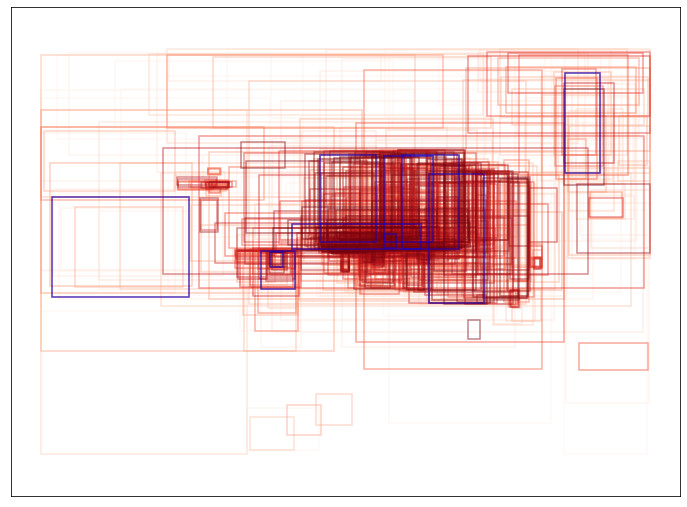

In [78]:
fig=plt.figure(figsize=(12,9))
ax = plt.gca()
scatter(proposals_tensors, ax = ax, format='proposals', top=1000)
scatter(retained_proposals, ax=ax, format='proposals',color='blue')

In [79]:
from detectron2.structures import pairwise_iou

#Naive estimation of the bounding box density

#1- Put the NMS output in the box format
retained_boxes = proposals.proposal_boxes[inds]
retained_boxes = retained_boxes[:10, :]

#2- Compute pair-wise IoUs
iou = pairwise_iou(retained_boxes, proposals.proposal_boxes)


#3- Estimate the mixture parameters sequentially
processed=0
for i in range(len(retained_boxes)):
    current_cluster=proposals.proposal_boxes[iou[i, :] >= nms_thr]
    
    cluster_size = len(current_cluster)
    processed += cluster_size
    print('{} boxes in cluster {}'.format(cluster_size, i))
    
print('{} boxes (/{}) used to estimate the mixture parameters'.format(processed, len(proposals.proposal_boxes)))

17 boxes in cluster 0
16 boxes in cluster 1
11 boxes in cluster 2
9 boxes in cluster 3
19 boxes in cluster 4
8 boxes in cluster 5
12 boxes in cluster 6
13 boxes in cluster 7
11 boxes in cluster 8
7 boxes in cluster 9
123 boxes (/1000) used to estimate the mixture parameters
